In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    clean_plot_labels,
    format_pval,
    savefig
)
from rl_analysis.regression import model_fit
from rl_analysis.io.df import dlight_exclude
from rl_analysis.util import count_transitions, pd_zscore
from sklearn import model_selection, linear_model
from joblib import Parallel, delayed
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# Helper functions

In [3]:
def split_array(x, mapping=None, index_name="syllable"):
    index = pd.Series(np.arange(len(x)))
    rows = pd.Series(data=x.tolist(), index=index.map(mapping))
    rows.index.name = index_name
    return rows

In [4]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_common"]
regression_cfg = analysis_config["dlight_regression"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [6]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [7]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")

In [8]:
use_neural_features = lagged_cfg["use_neural_features"]
use_windows = lagged_cfg["use_windows"]

In [9]:
use_features = []
for _use_win in use_windows:
    use_features += [f"{_}_{_use_win}" for _ in use_neural_features]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

# Loading in features for correlation

In [10]:
partition_cols = ["area", "mouse_id", "uuid"]

feature_df = pd.read_parquet(features_save_file)
rle_df = pd.read_parquet(rle_save_file)

feature_df[partition_cols] = feature_df[partition_cols].astype("str")
rle_df[partition_cols] = rle_df[partition_cols].astype("str")

In [12]:
use_area = "dls"

dlight_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("area", "=", use_area)],
)
dlight_df = dlight_df.drop_duplicates("uuid")

In [13]:
feature_df = feature_df.loc[feature_df["area"] == use_area].copy()
feature_df = feature_df.loc[feature_df["duration"] > 0.3].copy()

feature_df = dlight_exclude(
    feature_df, exclude_3s=False, syllable_key="syllable", **dlight_cfg
)
rle_df = rle_df.loc[rle_df["uuid"].isin(feature_df["uuid"])].copy()

In [14]:
try:
    feature_df = feature_df.set_index("window_tup", append=True)
except KeyError:
    pass

In [15]:
wins = feature_df.index.get_level_values(-1).unique()

In [16]:
idx = pd.IndexSlice

In [17]:
use_scalars = [
    "velocity_2d_mm_mean",
    "acceleration_2d_mm_mean",
    "velocity_angle_mean",
    "velocity_height_mean",
    "jerk_2d_mm_mean",
]

In [18]:
dfs = []
for _idx in tqdm(wins):
    use_vals = feature_df.loc[
        idx[:, _idx],
        use_neural_features + ["signal_reref_dff_z_idxmax"] + use_scalars,
    ]
    use_vals.columns = [f"{_}_{_idx}" for _ in use_vals.columns]
    use_vals.index = use_vals.index.droplevel(-1)
    dfs.append(use_vals)

meta_cols = feature_df.columns.difference(feature_df.filter(regex="dff").columns)

meta_df = feature_df[meta_cols].loc[idx[:, _idx], :]
meta_df.index = meta_df.index.droplevel(-1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
feature_df = pd.concat(dfs, axis=1).join(meta_df)

## Merge in entropy, usage and duration

In [20]:
feature_df = pd.merge(
    feature_df,
    dlight_df[dlight_df.columns.difference(feature_df.columns).tolist() + ["uuid"]],
    on="uuid",
    how="left",
)

In [21]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], "syllable_stats_photometry_offline.toml")
)

mapping = {int(k): int(v) for k, v in syllable_stats["syllable_to_sorted_idx"].items()}
reverse_mapping = {
    int(k): int(v) for k, v in syllable_stats["sorted_idx_to_syllable"].items()
}

In [22]:
rle_df = rle_df.loc[rle_df["syllable"] >= 0].copy()
rle_df["syllable_sorted"] = rle_df["syllable"].map(mapping)
tm_df = rle_df.groupby("uuid")["syllable_sorted"].apply(
    lambda x: count_transitions(x, K=len(mapping))
)

tm_df_rows = tm_df.apply(lambda x: split_array(x, mapping=reverse_mapping)).stack()
tm_df_rows = tm_df_rows.apply(lambda x: np.array(x))

tm_df_rows = tm_df_rows.rename("tm_row")

In [23]:
feature_df = pd.merge(feature_df, tm_df_rows, how="left", on=["uuid", "syllable"])

In [24]:
all_channel_features = use_features
all_scalars = feature_df.filter(regex="^(vel|acc|jerk)").columns.tolist()
feature_df[all_scalars] = feature_df.groupby("uuid")[all_scalars].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [25]:
durations = rle_df.groupby(["uuid", "session_number", "mouse_id"])["timestamp"].apply(
    lambda x: x.shift(-1) - x
)
rle_df["duration"] = durations

/tmp/ipykernel_1342178/793529411.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  durations = rle_df.groupby(["uuid", "session_number", "mouse_id"])["timestamp"].apply(


In [26]:
feature_df.drop_duplicates("uuid").groupby(["mouse_id"]).size()

mouse_id
dlight-chrimson-1    44
dlight-chrimson-2    37
dlight-chrimson-3    50
dlight-chrimson-4    17
dlight-chrimson-5    50
dlight-chrimson-6    46
dlight-chrimson-8    15
dlight-chrimson-9    16
dls-dlight-1         18
dls-dlight-2         19
dls-dlight-3         20
dls-dlight-4         17
dls-dlight-5         17
dls-dlight-7         13
dtype: int64

# Averaging prior to regression

In [27]:
group_keys = ["uuid", "session_number", "mouse_id", "syllable"]
# group_keys = ["mouse_id", "syllable"]
ave_usages = rle_df.groupby(group_keys[:-1])["syllable"].value_counts().rename("count")
ave_durations = rle_df.groupby(group_keys)["duration"].mean().rename("duration")
total_durations = rle_df.groupby(group_keys)["duration"].sum().rename("total_duration")

ave_syll_features = pd.concat([ave_usages, ave_durations, total_durations], axis=1)
ave_neural_features = feature_df.groupby(group_keys, observed=True)[
    all_channel_features + all_scalars
].mean()

ave_neural_features = ave_neural_features.drop(
    ave_syll_features.columns, axis=1, errors="ignore"
)
ave_features = ave_neural_features.join(ave_syll_features)

ave_features = ave_features.reset_index()

In [28]:
entropy_group_keys = ["mouse_id", "syllable", "uuid"]
# entropy_group_keys = ["mouse_id","syllable"]
if "uuid" not in entropy_group_keys:
    tm_df = feature_df.groupby(entropy_group_keys)["tm_row"].sum()
else:
    tm_df = feature_df.set_index(entropy_group_keys)["tm_row"]

In [29]:
tqdm.pandas()

In [30]:
tm_df = tm_df.loc[~tm_df.apply(np.isscalar)]

In [31]:
syllable_stats["truncate"]

37

In [32]:
from rl_analysis.info.util import dm_entropy

truncate = lagged_cfg["entropy"]["tm_truncate"]
ents = tm_df.progress_apply(
    lambda x: dm_entropy(
        x[: syllable_stats["truncate"]],
        alpha=1.0 / truncate,
        marginalize=False,
        axis=None,
    )
).rename("entropy_out")

  0%|          | 0/793362 [00:00<?, ?it/s]

In [33]:
ave_features = ave_features.drop(ents.name, axis=1, errors="ignore")
ave_features = pd.merge(
    ave_features, ents.reset_index(), how="left", on=entropy_group_keys
)

# Normalization

In [34]:
sorted_usages = ave_usages.groupby("syllable").mean().sort_values()[::-1]
sorted_usages /= sorted_usages.sum()
use_syllables = sorted_usages[sorted_usages > 0.01].index

In [35]:
z_keys = ["mouse_id"]
z_features = all_channel_features + all_scalars

ave_features_z_between = ave_features.dropna(subset=["count"]).copy().reset_index()

if z_keys is not None:
    ave_features_z_between[z_features] = ave_features_z_between.groupby(z_keys)[
        z_features
    ].transform(
        pd_zscore,
    )

try:
    ave_features_z_between = ave_features_z_between.reset_index()
except ValueError:
    pass

In [36]:
z_features = sorted(
    list(
        set(
            all_channel_features
            + ["count", "duration", "total_duration", "entropy_out"]
            + all_scalars
        )
    )
)
z_keys = ["mouse_id", "syllable"]

ave_features_z_within = ave_features.dropna(subset=["count"]).copy().reset_index()

if z_keys is not None:
    ave_features_z_within[z_features] = ave_features_z_within.groupby(z_keys)[
        z_features
    ].transform(
        pd_zscore,
    )
ave_features_z_within = ave_features_z_within.reset_index()

# Preparing features for between regression

In [37]:
xs = []
for _use_window in use_windows:
    xs += [
        f"signal_reref_dff_z_max_{_use_window}",
    ]
ys = [
    "count",
    "entropy_out",
]

In [38]:
xs = [_ for _ in xs if _ in feature_df.keys()]

In [39]:
usage = (
    rle_df.loc[rle_df["uuid"].isin(feature_df["uuid"].unique().tolist())]
    .groupby(["mouse_id"], observed=True)["syllable"]
    .value_counts(normalize=False)
)

usage = usage[usage.index.get_level_values("syllable") != -5]
use_syllables = usage.index

In [40]:
final_group_keys = ["mouse_id", "syllable"]
# final groupby prior to running the regression
use_features_z_between = ave_features_z_between.groupby(
    final_group_keys, observed=True
).mean()

/tmp/ipykernel_1342178/2577574489.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()


# Preparing features for within regression...

In [41]:
final_group_keys = ["syllable", "uuid", "mouse_id"]
use_features_z_within = (ave_features_z_within.groupby(final_group_keys).mean()).dropna(
    subset=use_features
)

plt_features_within = use_features_z_within

usage_mean = (
    rle_df.groupby(["mouse_id", "uuid"])["syllable"]
    .value_counts(normalize=False)
    .groupby(["syllable", "mouse_id"])
    .mean()
)

usage_mean = usage_mean[usage_mean.index.get_level_values("syllable") != -5]

# Model based estimate (between)

In [42]:
ci = 0.95
nshuffles = 1000
partial_vars = None

In [43]:
kwargs = {
    "ci": 68,
    "x_ci": 68,
    "x_estimator": np.nanmean,
    "scatter_kws": {"s": 6},
}

In [44]:
line_ax_kwargs = {
    "xlim": (-3, 3),
    #     "ylim": (-.7, .7)
}

fig_kwargs = {
    "figsize": (2.5, 1.1 * len(ys)),
    "sharex": "col",
    "sharey": False,
    "gridspec_kw": {"width_ratios": [2, 1]},
}

In [45]:
# shuffle splits are repeated nshuffles times
shuffle_splits = model_selection.RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

# this is done once to estimate a CI for the fit we show and the r (computed over held-out data)
# one potential issue is that we're repeating datapoints, so we could reduce the number of repeats
obs_splits = model_selection.RepeatedKFold(n_splits=5, n_repeats=100, random_state=0)

In [46]:
# model features are average to mouse/syllable pairs first...
model_features_z = (
    use_features_z_between.loc[usage[usage >= 100].index].copy().reset_index()
)

In [47]:
model_features_z.groupby("mouse_id").size()

mouse_id
dlight-chrimson-1    56
dlight-chrimson-2    54
dlight-chrimson-3    57
dlight-chrimson-4    53
dlight-chrimson-5    56
dlight-chrimson-6    57
dlight-chrimson-8    56
dlight-chrimson-9    54
dls-dlight-1         50
dls-dlight-2         54
dls-dlight-3         53
dls-dlight-4         51
dls-dlight-5         56
dls-dlight-7         53
dtype: int64

In [48]:
model_features_z["velocity_2d_mm"] = model_features_z["velocity_2d_mm_mean_(0.0, 0.3)"]
model_features_z["acceleration_2d_mm"] = model_features_z[
    "acceleration_2d_mm_mean_(0.0, 0.3)"
]
model_features_z["velocity_angle"] = model_features_z["velocity_angle_mean_(0.0, 0.3)"]
model_features_z["velocity_height"] = model_features_z[
    "velocity_height_mean_(0.0, 0.3)"
]
model_features_z["jerk_2d_mm"] = model_features_z["jerk_2d_mm_mean_(0.0, 0.3)"]

In [49]:
ylimits = {
    "count": [-25, 300],
    "total_duration": [-50, 150],
    "duration": [0, 1.5],
    "entropy_out": [2, 4.5],
    "velocity_2d_mm": [-2, 4],
    "velocity_angle": [-5, 5],
    "acceleration_2d_mm": [-2, 2],
    "velocity_height": [-2, 2],
    "jerk_2d_mm": [-2, 2],
}

In [50]:
aliases = {
    "count": "Syll. counts",
    "total_duration": "Time in syll. (s)",
    "duration": "Syll. duration (s)",
    "entropy_out": "Entropy (nats)",
    "velocity_2d_mm": "Vel. (z)",
    "acceleration_2d_mm": "Acc.",
    "velocity_height": "Z Vel.",
    "velocity_angle": "Ang. Vel.",
    "jerk_2d_mm": "Jerk",
}

In [51]:
color = sns.color_palette()[1]

In [52]:
partial_vars = None
shuffle_bins = np.arange(-0.4, 0.4, 0.025)

In [53]:
def get_z(x, y, bw_adjust=1):
    from scipy.stats import gaussian_kde

    xy = np.vstack([x, y])
    kernel = gaussian_kde(xy)
    kernel.set_bandwidth(kernel.scotts_factor() * bw_adjust)
    z = kernel(xy)
    return z

In [54]:
stats = {}
stats["between"] = {}
stats["between"]["n_syllable_mouse_pairs"] = len(model_features_z)

In [55]:
plt_models = {}
plt_points = {}

dcts = []
for _x in tqdm(xs):
    for _y in tqdm(ys):
        clf = linear_model.HuberRegressor(fit_intercept=True, epsilon=1.05)
        delays = [
            delayed(model_fit)(
                model_features_z,
                clf=clf,
                shuffle_x=True,
                random_state=i,
                partial_x=partial_vars,
                y=_y,
                x=_x,
                splits=shuffle_splits,
            )
            for i in range(nshuffles)
        ]

        results = Parallel(n_jobs=-1, verbose=0)(delays)
        obs_r, models, (plt_x, plt_y) = model_fit(
            model_features_z,
            clf=clf,
            return_models=True,
            partial_x=partial_vars,
            y=_y,
            x=_x,
            return_input=True,
            splits=obs_splits,
        )

        p = (obs_r < results).mean()
        plt_models[(_x, _y)] = models
        plt_points[(_x, _y)] = (plt_x, plt_y)

        dct = {"r": obs_r, "p": p, "x": _x, "y": _y}
        dcts.append(dct)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
from statsmodels.stats.multitest import multipletests

between_pval_df = pd.DataFrame(dcts)
between_pval_df["p"] = between_pval_df.groupby("x")["p"].transform(
    lambda x: multipletests(x.to_list(), method="holm")[1]
)
between_pval_df = between_pval_df.set_index(["x", "y"])

  0%|          | 0/2 [00:00<?, ?it/s]

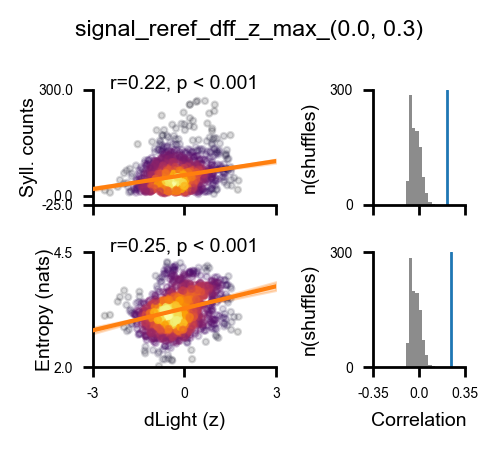

In [58]:
setup_plotting_env()
for _x in xs:
    fig, ax = plt.subplots(len(ys), 2, **fig_kwargs)
    xvals = np.linspace(-3, 3, 100)

    for rax, _y in tqdm(zip(ax, ys), total=len(ax)):

        obs_r = between_pval_df.loc[_x, _y]["r"]
        p = between_pval_df.loc[_x, _y]["p"]
        models = plt_models[(_x, _y)]
        plt_x, plt_y = plt_points[(_x, _y)]

        stats["between"][f"{_x}-{_y}"] = {}
        stats["between"][f"{_x}-{_y}"]["r"] = obs_r
        stats["between"][f"{_x}-{_y}"]["p"] = p
        predictions = np.array([_.predict(xvals.reshape(-1, 1)) for _ in models])
        x = plt_x.values.ravel()
        y = plt_y.values.ravel()

        z = get_z(x, y, 1)
        z /= z.max()

        rax[0].scatter(
            x,
            y,
            c=z,
            s=5,
            cmap="inferno",
            alpha=np.clip(z, 0.15, 0.8),
            rasterized=True,
            clip_on=True,
        )

        rax[0].set_ylim(ylimits[_y])
        rax[0].set_ylabel(aliases[_y] if _y in aliases.keys() else _y)
        ci_hi = np.quantile(predictions, (1 - (1 - ci) / 2), axis=0)
        ci_lo = np.quantile(predictions, (1 - ci) / 2, axis=0)
        mu = np.mean(predictions, axis=0)

        rax[0].fill_between(xvals, ci_lo, ci_hi, zorder=-200, alpha=0.25, color=color)
        rax[0].plot(xvals, mu, zorder=+150, alpha=1, color=color, lw=1.5)
        rax[0].text(
            0.5,
            1.05,
            f"r={obs_r:.2f}, {format_pval(p)[0]}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=rax[0].transAxes,
            zorder=+300,
        )

        sns.histplot(
            results,
            ax=rax[1],
            bins=shuffle_bins,
            color=[0.4, 0.4, 0.4],
            element="step",
            fill=True,
            ec=None,
            lw=0,
        )
        rax[1].axvline(x=obs_r)
        rax[0].set_ylabel(rax[0].get_ylabel(), labelpad=0)
        rax[1].set_ylabel("n(shuffles)")

    plt.setp(ax, xlabel="")
    ax[-1, 0].set_xlabel("dLight (z)")
    ax[-1, 1].set_xlabel("Correlation")

    plt.setp(ax[:, 1], ylim=(0, 300), xlim=(-0.35, +0.5))
    for _ax in ax[:, 1]:
        _ax.set_xlim(-0.35, 0.35)
        clean_ticks(_ax, "x", zero_symmetry=True, precision=2)
        clean_ticks(_ax, "y", zero_symmetry=False, precision=-2, dtype=int)

    if len(line_ax_kwargs.keys()) > 0:
        plt.setp(ax[:, 0], **line_ax_kwargs)

    for _ax in ax[:, 0]:
        clean_ticks(_ax, "y", zero_symmetry=False, precision=1, dtype=float)
        clean_ticks(_ax, "x", zero_symmetry=True, precision=0, dtype=int)

    sns.despine()
    fig.suptitle(_x)
    fig.tight_layout()
    plt.show()

    savefig(
        fig,
        os.path.join(
            figure_cfg["store_dir"],
            f"correlation_heldout_mouse_syllable_pairs_between-syllable_{_x}-{use_area}",
        ),
        bbox_inches="tight",
        dpi=300,
    )

# Model estimate (within)

In [59]:
use_syllables = usage_mean[(usage_mean > 50)].index
model_features_z = plt_features_within.reset_index().set_index(
    ["syllable", "mouse_id"]
)
model_features_z = (
    model_features_z.loc[use_syllables.intersection(model_features_z.index)]
    .groupby(["uuid"])
    .mean()
    .reset_index()
)

In [60]:
kwargs = {
    #     "x_bins": np.linspace(-10,10,10)[:-1],
    "x_bins": 8,
    "ci": 68,
    "x_ci": 68,
    "x_estimator": np.nanmean,
    "scatter_kws": {"s": 6},
}
line_ax_kwargs_within = {
    #     "xlim": (-1.15, 1.15),
    #     "ylim": (-.7, .7)
}

fig_kwargs = {
    "figsize": (2.5, 1.1 * len(ys)),
    "sharex": "col",
    "sharey": False,
    "gridspec_kw": {"width_ratios": [2, 1]},
}

In [61]:
ylimits = {
    "count": [-1.25, 0.5],
    "total_duration": [-1.25, 0.5],
    "duration": [-1.5, 1.5],
    "entropy_out": [-1, 1],
    "velocity_2d_mm": [-2, 2],
    "jerk_2d_mm": [-1, 1],
    "acceleration_2d_mm": [-1, 1],
    "velocity_angle": [-1, 1],
    "velocity_height": [-1, 1],
}

In [62]:
model_features_z["velocity_2d_mm"] = model_features_z["velocity_2d_mm_mean_(0.0, 0.3)"]
model_features_z["acceleration_2d_mm"] = model_features_z[
    "acceleration_2d_mm_mean_(0.0, 0.3)"
]
model_features_z["velocity_angle"] = model_features_z["velocity_angle_mean_(0.0, 0.3)"]
model_features_z["velocity_height"] = model_features_z[
    "velocity_height_mean_(0.0, 0.3)"
]

In [63]:
stats["within"] = {}

In [64]:
stats["within"]["n_sessions"] = len(model_features_z)

In [65]:
plt_models = {}
plt_points = {}

dcts = []
for _x in tqdm(xs):
    for _y in tqdm(ys):
        clf = linear_model.HuberRegressor(fit_intercept=True, epsilon=1.05)
        delays = [
            delayed(model_fit)(
                model_features_z,
                clf=clf,
                shuffle_x=True,
                partial_x=partial_vars,
                y=_y,
                x=_x,
                random_state=i,
                splits=shuffle_splits,
            )
            for i in range(nshuffles)
        ]

        results = Parallel(n_jobs=-1, verbose=0)(delays)
        obs_r, models, (plt_x, plt_y) = model_fit(
            model_features_z,
            clf=clf,
            return_models=True,
            partial_x=partial_vars,
            y=_y,
            x=_x,
            return_input=True,
            splits=obs_splits,
        )

        p = (obs_r < results).mean()
        plt_models[(_x, _y)] = models
        plt_points[(_x, _y)] = (plt_x, plt_y)

        dct = {"r": obs_r, "p": p, "x": _x, "y": _y}
        dcts.append(dct)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [66]:
within_pval_df = pd.DataFrame(dcts)
within_pval_df["p"] = within_pval_df.groupby("x")["p"].transform(
    lambda x: multipletests(x.to_list(), method="holm")[1]
)
within_pval_df = within_pval_df.set_index(["x", "y"])

  0%|          | 0/2 [00:00<?, ?it/s]

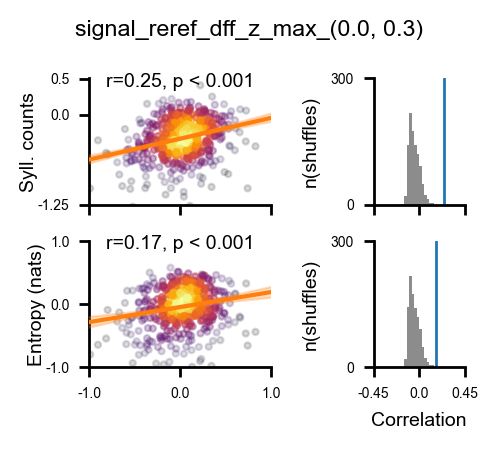

In [67]:
setup_plotting_env()

for _x in xs:
    fig, ax = plt.subplots(len(ys), 2, **fig_kwargs)
    xvals = np.linspace(-3, 3, 100)

    for rax, _y in tqdm(zip(ax, ys), total=len(ax)):

        obs_r = within_pval_df.loc[_x, _y]["r"]
        p = within_pval_df.loc[_x, _y]["p"]
        models = plt_models[(_x, _y)]
        plt_x, plt_y = plt_points[(_x, _y)]

        stats["within"][f"{_x}-{_y}"] = {}
        stats["within"][f"{_x}-{_y}"]["r"] = obs_r
        stats["within"][f"{_x}-{_y}"]["p"] = p
        predictions = np.array([_.predict(xvals.reshape(-1, 1)) for _ in models])

        x = plt_x.values.ravel()
        y = plt_y.values.ravel()

        z = get_z(x, y, 1)
        z /= z.max()

        rax[0].scatter(
            x, y, c=z, s=5, cmap="inferno", alpha=np.clip(z, 0.15, 0.8), rasterized=True
        )
        rax[0].set_ylim(ylimits[_y])
        rax[0].set_ylabel(aliases[_y] if _y in aliases.keys() else _y)

        ci_hi = np.quantile(predictions, (1 - (1 - ci) / 2), axis=0)
        ci_lo = np.quantile(predictions, (1 - ci) / 2, axis=0)
        mu = np.mean(predictions, axis=0)
        rax[0].fill_between(xvals, ci_lo, ci_hi, zorder=+200, alpha=0.25, color=color)
        rax[0].plot(xvals, mu, zorder=+250, alpha=1, color=color, lw=1.5)
        rax[0].text(
            0.5,
            0.975,
            f"r={obs_r:.2f}, {format_pval(p)[0]}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=rax[0].transAxes,
            zorder=+300,
        )

        sns.histplot(
            results,
            ax=rax[1],
            bins=shuffle_bins,
            color=[0.4, 0.4, 0.4],
            element="step",
            fill=True,
            ec=None,
            lw=0,
        )
        rax[1].axvline(x=obs_r)

        rax[0].set_ylabel(rax[0].get_ylabel(), labelpad=0)
        rax[1].set_ylabel("n(shuffles)")

    plt.setp(ax, xlabel="")
    ax[-1, 0].set_xlabel("dLight (z)")
    ax[-1, 1].set_xlabel("Correlation")

    plt.setp(ax[:, 1], ylim=(0, 300), xlim=(-0.35, +0.35))
    for _ax in ax[:, 1]:
        _ax.set_xlim(-0.45, 0.45)
        clean_ticks(_ax, "x", zero_symmetry=True, precision=2)
        clean_ticks(_ax, "y", zero_symmetry=False, precision=-2, dtype=int)

    # plt.setp(ax[:, 0], xlim=(-1, 1))
    for _ax in ax[:, 0]:
        _ax.set_xlim(-1, 1)
        clean_ticks(_ax, "x", zero_symmetry=True, precision=1)
        clean_ticks(_ax, "y", zero_symmetry=False, precision=2)

    plt.setp(ax, xlabel="")
    ax[0][-1].set_xlabel("dLight (z)")
    ax[1][-1].set_xlabel("Correlation")

    sns.despine()
    fig.suptitle(_x)
    fig.tight_layout()

    savefig(
        fig,
        os.path.join(
            figure_cfg["store_dir"],
            f"correlation_heldout_mouse_syllable_pairs_within-syllable_{_x}-{use_area}",
        ),
        bbox_inches="tight",
        dpi=300,
    )